<a href="https://colab.research.google.com/github/jtianesq/havardsfa/blob/master/SFAv1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [2]:
# load dataset
url = "https://raw.githubusercontent.com/jtianesq/havardsfa/master/sfa_combined_raw.csv"
dataframe = pd.read_csv(url,sep="|",header=0,encoding='windows-1252') #the encoding part is necessary!!!
print(dataframe.head(5))

    Score                                           Industry  Year Founded  \
0  Accept  hazardous materials and inspection training se...          1982   
1  Accept                       commercial cleaning services          1983   
2  Accept                                water tank services          1962   
3  Accept                  oil and propane delivery services          1981   
4  Accept                         energy inspection services          1986   

                           URLtrim  Recurring Revenue (million) Margins  \
0                     aidtrain.com                          0.5  medium   
1          alliancemaintenance.com                          0.5     low   
2          americanpipeandtank.com                          0.5  medium   
3  beaudryoilpropanedieselfuel.com                          0.5     low   
4               cci-inspection.com                          0.5  medium   

  Stable Cash Flow Industry Growth Fragmented Industry  \
0              low    

In [3]:
print(dataframe.columns)
print(dataframe.shape)

Index(['Score', 'Industry', 'Year Founded', 'URLtrim',
       'Recurring Revenue (million)', 'Margins', 'Stable Cash Flow',
       'Industry Growth', 'Fragmented Industry', 'Straightforward Operations',
       'Exogenous Risk', 'Barriers to Entry', 'Employee Estimate',
       'Stickiness', 'Supplier Power', 'Customer Power',
       'Service vs Project/Product', 'Longterm Relationships',
       'Customer Concentration'],
      dtype='object')
(236, 19)


In [4]:
#data exploration
dataframe['Score'].value_counts()

Reject    192
Accept     43
reject      1
Name: Score, dtype: int64

In [5]:
#There is a record with value 'reject' instead of 'Reject', fix this issue with the following code
dataframe['Score']=np.where(dataframe['Score'] =='reject', 'Reject', dataframe['Score'])
dataframe['Score']=np.where(dataframe['Score'] =='Reject', 0, dataframe['Score'])
dataframe['Score']=np.where(dataframe['Score'] =='Accept', 1, dataframe['Score'])
dataframe['Score']=dataframe['Score'].astype(int)
dataframe['Score'].value_counts()

0    193
1     43
Name: Score, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


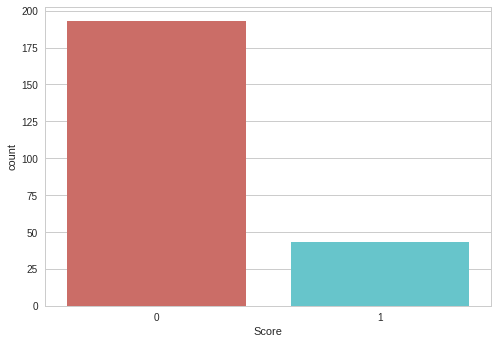

In [6]:
sns.countplot(x='Score',data=dataframe, palette='hls')
plt.show()

The sample is unbalaneced.  As shown in the calculation below, the ratio of reject to accept is 83:16.

In [7]:
count_reject = len(dataframe[dataframe['Score']==0])
count_accept = len(dataframe[dataframe['Score']==1])
pct_of_reject = count_reject/(count_reject + count_accept)
print("percentage of reject is", pct_of_reject*100)
pct_of_accept = count_accept/(count_reject+count_accept)
print("percentage of accept", pct_of_accept*100)

percentage of reject is 81.77966101694916
percentage of accept 18.220338983050848


In [8]:
dataframe.groupby('Score').mean()

,Year Founded,Recurring Revenue (million)
Score,,
0,1989.362694,9.881969
1,1991.255814,9.741860


As shown above, there is a big difference between the mean of Recurrening Revenue of Accepted and Rejected records. This is caused by few large companies in the dataset with large amount of revenue and employee size which are way above the limit of search fund acquisition. These outliner should be excluded from the dataset.

In [9]:
dataframe.describe()

,Score,Year Founded,Recurring Revenue (million)
count,236.000000,236.000000,236.000000
mean,0.182203,1989.707627,9.856441
std,0.386832,23.365625,12.842066
min,0.000000,1873.000000,0.050000
25%,0.000000,1980.000000,0.500000
50%,0.000000,1995.000000,4.150000
75%,0.000000,2008.000000,13.000000
max,1.000000,2016.000000,72.000000


The maximum value for Recurring Revuenue is 23000 which is way out of range since the 75% quatile is 20. Therefore, in the next step, I filtered out records with Recurring Revenue > 30. After that, the mean value for Recurring Revenue from Accept and Reject subsets looks similar.

In [10]:
dataframe=dataframe[dataframe['Recurring Revenue (million)']<=30]
dataframe.groupby('Score').mean()

,Year Founded,Recurring Revenue (million)
Score,,
0,1990.237288,6.978644
1,1992.150000,6.572500


Calculate categorical means for other categorical variables to better understand the distribution of the data

In [11]:
dataframe.groupby('Margins').mean()

,Score,Year Founded,Recurring Revenue (million)
Margins,,,
high,0.666667,1996.000000,6.733333
low,0.156250,1993.250000,4.943958
medium,0.194915,1988.288136,8.502542


In [12]:
dataframe.groupby('Stable Cash Flow').mean()

,Score,Year Founded,Recurring Revenue (million)
Stable Cash Flow,,,
high,1.000000,1995.000000,7.000000
low,0.205298,1992.549669,5.474967
medium,0.123077,1985.969231,10.221538


In [13]:
dataframe.groupby('Industry Growth').mean()

,Score,Year Founded,Recurring Revenue (million)
Industry Growth,,,
high,0.130435,1997.217391,9.304348
low,0.194444,1983.263889,5.980556
medium,0.202020,1992.838384,6.459798


In [14]:
dataframe.groupby('Employee Estimate').mean()

,Score,Year Founded,Recurring Revenue (million)
Employee Estimate,,,
11-50,0.225352,1994.535211,6.361972
2-10,0.203125,1997.296875,1.544063
201-1000,0.000000,1998.000000,10.750000
51-200,0.148649,1980.202703,11.643243


Do one-hot-encoding for all categorical variables by creating dummy variables

In [15]:
cat_vars=['Margins', 'Stable Cash Flow',
       'Industry Growth', 'Fragmented Industry', 'Straightforward Operations',
       'Exogenous Risk', 'Barriers to Entry', 'Employee Estimate',
       'Stickiness', 'Supplier Power', 'Customer Power',
       'Service vs Project/Product', 'Longterm Relationships',
       'Customer Concentration']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(dataframe[var], prefix=var)
    dataframe1=dataframe.join(cat_list)
    dataframe=dataframe1
    
cat_vars=['Margins', 'Stable Cash Flow',
       'Industry Growth', 'Fragmented Industry', 'Straightforward Operations',
       'Exogenous Risk', 'Barriers to Entry', 'Employee Estimate',
       'Stickiness', 'Supplier Power', 'Customer Power',
       'Service vs Project/Product', 'Longterm Relationships',
       'Customer Concentration','Industry', 'URLtrim']
dataframe_vars=dataframe.columns.values.tolist()
to_keep=[i for i in dataframe_vars if i not in cat_vars]
dataframe_final=dataframe[to_keep]
dataframe_final.columns.values

array(['Score', 'Year Founded', 'Recurring Revenue (million)',
       'Margins_high', 'Margins_low', 'Margins_medium',
       'Stable Cash Flow_high', 'Stable Cash Flow_low',
       'Stable Cash Flow_medium', 'Industry Growth_high',
       'Industry Growth_low', 'Industry Growth_medium',
       'Fragmented Industry_high', 'Fragmented Industry_low',
       'Fragmented Industry_medium', 'Straightforward Operations_no',
       'Straightforward Operations_yes', 'Exogenous Risk_high',
       'Exogenous Risk_low', 'Exogenous Risk_medium',
       'Barriers to Entry_high', 'Barriers to Entry_low',
       'Barriers to Entry_medium', 'Employee Estimate_11-50',
       'Employee Estimate_2-10', 'Employee Estimate_201-1000',
       'Employee Estimate_51-200', 'Stickiness_high', 'Stickiness_low',
       'Stickiness_medium', 'Supplier Power_high', 'Supplier Power_low',
       'Supplier Power_medium', 'Customer Power_high',
       'Customer Power_medium', 'Service vs Project/Product_product',
       '

Oversampling using SMOTE


In [0]:
X = dataframe_final.loc[:, dataframe_final.columns != 'Score']
y = dataframe_final.loc[:, dataframe_final.columns == 'Score']

In [17]:
!pip install imblearn

In [18]:
from imblearn.over_sampling import SMOTE

os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns

os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['Score'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of reject in oversampled data",len(os_data_y[os_data_y['Score']==0]))
print("Number of accept data",len(os_data_y[os_data_y['Score']==1]))
print("Proportion of reject data in oversampled data is ",len(os_data_y[os_data_y['Score']==0])/len(os_data_X))
print("Proportion of accept data in oversampled data is ",len(os_data_y[os_data_y['Score']==1])/len(os_data_X))

length of oversampled data is  238
Number of reject in oversampled data 119
Number of accept data 119
Proportion of reject data in oversampled data is  0.5
Proportion of accept data in oversampled data is  0.5


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [19]:
data_final_vars=dataframe_final.columns.values.tolist()
y=['Score']
X=[i for i in data_final_vars if i not in y]

print(X)

['Year Founded', 'Recurring Revenue (million)', 'Margins_high', 'Margins_low', 'Margins_medium', 'Stable Cash Flow_high', 'Stable Cash Flow_low', 'Stable Cash Flow_medium', 'Industry Growth_high', 'Industry Growth_low', 'Industry Growth_medium', 'Fragmented Industry_high', 'Fragmented Industry_low', 'Fragmented Industry_medium', 'Straightforward Operations_no', 'Straightforward Operations_yes', 'Exogenous Risk_high', 'Exogenous Risk_low', 'Exogenous Risk_medium', 'Barriers to Entry_high', 'Barriers to Entry_low', 'Barriers to Entry_medium', 'Employee Estimate_11-50', 'Employee Estimate_2-10', 'Employee Estimate_201-1000', 'Employee Estimate_51-200', 'Stickiness_high', 'Stickiness_low', 'Stickiness_medium', 'Supplier Power_high', 'Supplier Power_low', 'Supplier Power_medium', 'Customer Power_high', 'Customer Power_medium', 'Service vs Project/Product_product', 'Service vs Project/Product_service', 'Longterm Relationships_no', 'Longterm Relationships_yes', 'Customer Concentration_high', 

Recursive Feature Elimination

In [20]:
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

rfe = RFE(logreg, 20)
rfe = rfe.fit(os_data_X.astype(float), os_data_y.values.ravel().astype(int))
print(rfe.support_)
print(rfe.ranking_)

[False False  True  True False False False False  True  True False False
 False False  True False False  True  True  True  True False False False
  True False False False  True False  True  True  True False  True  True
  True  True  True False  True]
[20 19  1  1  9 22 18  6  1  1 11  5 13 10  1  2 21  1  1  1  1  4 17 15
  1 16  3  7  1 14  1  1  1  8  1  1  1  1  1 12  1]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

In [21]:
#cols = ['Customer Concentration_medium']
cols = rfe.get_support().tolist() #list of booleans
new_features = [] # The list of your K best features

for bool, feature in zip(cols, os_data_X.columns.values):
    if bool:
        new_features.append(feature)
        
X=os_data_X[new_features]
y=os_data_y['Score']

print(os_data_y['Score'].unique())

[1 0]


In [22]:
print(X.columns)

Index(['Margins_high', 'Margins_low', 'Industry Growth_high',
       'Industry Growth_low', 'Straightforward Operations_no',
       'Exogenous Risk_low', 'Exogenous Risk_medium', 'Barriers to Entry_high',
       'Barriers to Entry_low', 'Employee Estimate_201-1000',
       'Stickiness_medium', 'Supplier Power_low', 'Supplier Power_medium',
       'Customer Power_high', 'Service vs Project/Product_product',
       'Service vs Project/Product_service', 'Longterm Relationships_no',
       'Longterm Relationships_yes', 'Customer Concentration_high',
       'Customer Concentration_medium'],
      dtype='object')


In [23]:
import statsmodels.api as sm
logit_model=sm.Logit(y.astype(int),X.astype(int))
result=logit_model.fit(method='bfgs')
print(result.summary2())

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.349670
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
                                  Results: Logit
Model:                     Logit                  Pseudo R-squared:       0.496   
Dependent Variable:        Score                  AIC:                    206.4431
Date:                      2018-12-02 11:08       BIC:                    275.8885
No. Observations:          238                    Log-Likelihood:         -83.222 
Df Model:                  19                     LL-Null:                -164.97 
Df Residuals:              218                    Scale:                  1.0000  
Converged:                 0.0000                                                 
----------------------------------------------------------------------------------
                                    Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
----------------------------------------------------------------------

Drop the columns with higher P values

Logistic Regression Model Fitting

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train.astype(float), y_train.astype(int))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [25]:
y_pred = logreg.predict(X_test.astype(float))
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.78


Confusion Matrix

In [26]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[23  8]
 [ 8 33]]


In [27]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.74      0.74        31
           1       0.80      0.80      0.80        41

   micro avg       0.78      0.78      0.78        72
   macro avg       0.77      0.77      0.77        72
weighted avg       0.78      0.78      0.78        72




Interpretation:
Of the entire test set, 74% of the promoted term deposit were the term deposit that the customers liked. Of the entire test set, 74% of the customer's preferred term deposit were promoted.

ROC curve

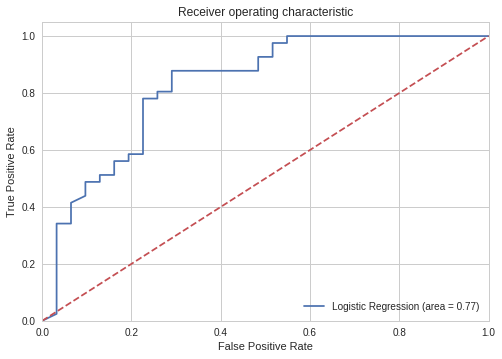

In [28]:

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Decision Tree

In [29]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier().fit(X_train, y_train)
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of Decision Tree classifier on training set: 0.95
Accuracy of Decision Tree classifier on test set: 0.75


K-Nearest Neighbors

In [30]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of K-NN classifier on training set: 0.86
Accuracy of K-NN classifier on test set: 0.83


Linear Discriminant Analysis

In [31]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
print('Accuracy of LDA classifier on training set: {:.2f}'
     .format(lda.score(X_train, y_train)))
print('Accuracy of LDA classifier on test set: {:.2f}'
     .format(lda.score(X_test, y_test)))

Accuracy of LDA classifier on training set: 0.83
Accuracy of LDA classifier on test set: 0.78


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Gaussian Naive Bayes

In [32]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
print('Accuracy of GNB classifier on training set: {:.2f}'
     .format(gnb.score(X_train, y_train)))
print('Accuracy of GNB classifier on test set: {:.2f}'
     .format(gnb.score(X_test, y_test)))

Accuracy of GNB classifier on training set: 0.63
Accuracy of GNB classifier on test set: 0.68


Support Vector Machine

In [33]:
from sklearn.svm import SVC
svm = SVC()
svm.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svm.score(X_test, y_test)))

Accuracy of SVM classifier on training set: 0.80
Accuracy of SVM classifier on test set: 0.75


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


The KNN algorithm was the most accurate model that we tried. The confusion matrix provides an indication of no error made on the test set. However, the test set was very small.

In [34]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
pred = knn.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[23  8]
 [ 4 37]]
              precision    recall  f1-score   support

           0       0.85      0.74      0.79        31
           1       0.82      0.90      0.86        41

   micro avg       0.83      0.83      0.83        72
   macro avg       0.84      0.82      0.83        72
weighted avg       0.83      0.83      0.83        72



With this dataset, accuracy is at the highest when k=5.

([<matplotlib.axis.XTick at 0x7f940b0ba550>,
 <a list of 5 Text xticklabel objects>)

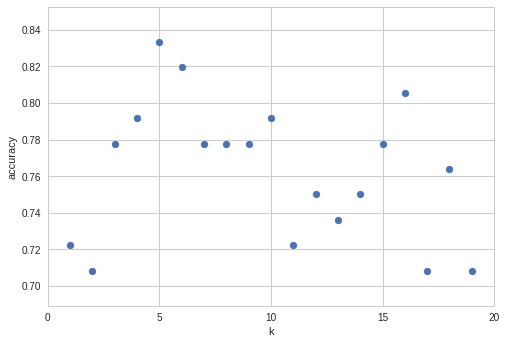

In [37]:
k_range = range(1, 20)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20])